In [50]:
import os
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

import seaborn as sns

# import nltk
# nltk.download('stopwords')

# from nltk.corpus import stopwords

!python -m spacy download en_core_web_sm
import spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 293.2 kB/s eta 0:00:0000:0100:02
You should consider upgrading via the '/Users/user/Downloads/code/app_dev/.dami_proj_venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [20]:
%cd "/content/drive/MyDrive/Dami's Thesis/code"

[Errno 2] No such file or directory: "/content/drive/MyDrive/Dami's Thesis/code"
/Users/user/Documents/Dami's Thesis/hotel-analytics/notebooks


In [22]:
data_path = "../fetched_data"

def read_multiple_csvs_in_dir(dir):
    csvs = os.listdir(dir)
    all_dfs = []

    for csv in csvs:
        print(csv)
        df = pd.read_csv(dir+"/"+csv)
        all_dfs.append(df)

    return all_dfs

multiple_dfs = read_multiple_csvs_in_dir(data_path)

eko_hotel4100.csv
sheraton_lagos3720.csv
lagos_oriental3540.csv
four_points_by_sheraton3970.csv
radisson_blu_VI3350.csv


In [18]:
multiple_dfs[0].head()

,rating,review,image_url
0,4/5,"This was the ""headquarters"" for the family whe...",[]
1,4/5,Excellent space for office programs/retreats. ...,[]
2,5/5,It's a beautiful place with cool fresh breeze ...,[]
3,5/5,A place I love to visit once in awhile because...,[]
4,5/5,"Beautiful, well decorated hotel in the heart o...",[]


In [19]:
multiple_dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rating     4100 non-null   object
 1   review     4100 non-null   object
 2   image_url  4100 non-null   object
dtypes: object(3)
memory usage: 96.2+ KB


__Text Cleaning__
- convert all empty lists([]) in "image_url" column to np.nan
- convert ratings to integer. For example, 4/5 becomes 4
- remove all urls, email addresses and phone numbers from the "review" column.

In [24]:
def clean_text_column(df, column_name):
    # regex patterns to match email addresses, phone numbers, and URLs
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    phone_pattern = r'\(?\+?\d{1,3}\)?[-.\s]?\d{1,5}[-.\s]?\d{1,5}[-.\s]?\d{1,5}'
    url_pattern = r'http\S+|www.\S+'

    # put text in lowercase
    df[column_name] = df[column_name].apply(lambda x: str(x).lower())
    
    # remove email addresses, phone numbers, and URLs from the specified column
    df[column_name] = df[column_name].apply(lambda x: re.sub(email_pattern, '', str(x)))
    df[column_name] = df[column_name].apply(lambda x: re.sub(phone_pattern, '', str(x)))
    df[column_name] = df[column_name].apply(lambda x: re.sub(url_pattern, '', str(x)))

    # # remove stopwords
    # stop_words = stopwords.words('english')
    # stop_words = stop_words + ["hotel", "hotels", "lagos", "nigeria", "nigerian", "place"]

    # df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in re.findall(r'\w+', x) if word not in (stop_words)]))
    
    return df

In [21]:
# def remove_stopwords(df, column_name):

#     # remove stopwords using nltk
#     stop_words = stopwords.words('english')
#     stop_words = stop_words + ["hotel", "lagos"]

#     df[column_name] = df[column_name].apply(lambda x: str(x).lower())   
#     df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in re.findall(r'\w+', x) if word not in (stop_words)]))

#     return df

In [25]:
# convert all [] in "image_url" to np.nan
# convert ratings to integer. For example, 4/5 becomes 4

for df in multiple_dfs:
    df["image_url"] = df["image_url"].replace("[]", np.nan)
    df["rating"] = df["rating"].apply(lambda x: str(x).split("/")[0])
    df = clean_text_column(df, "review")
    # df = remove_stopwords(df, "review")

In [26]:
eko_hotel = multiple_dfs[0]
radisson_blu_VI_hotel = multiple_dfs[1]
four_points_by_sheraton_hotel = multiple_dfs[2]
sheraton_lagos_hotel = multiple_dfs[3]
lagos_oriental_hotel = multiple_dfs[4]

In [24]:
eko_hotel.head()

,rating,review,image_url
0,4,"this was the ""headquarters"" for the family whe...",NaN
1,4,excellent space for office programs/retreats. ...,NaN
2,5,it's a beautiful place with cool fresh breeze ...,NaN
3,5,a place i love to visit once in awhile because...,NaN
4,5,"beautiful, well decorated hotel in the heart o...",NaN


__Topic Modelling__

To get a more accurate model, we split each review into sentences. Many reviews are made of many sentence, with each containing different info or topic and even of varying sentiments.

For example:
`excellent space for office programs/retreats. rooms were fair enough; spacious and neat. only issue i had was that the water in the bathroom wasn't hot enough. also, i didn't like that the bath had only half 'door/shield' because water still spilled out and the floor ended up being flooded despite the floor towel.food was great, we had dinner at sky restaurant. loved the buffet service.`

In [27]:
def split_reviews_into_new_rows(df, review_column):

    # Split the reviews by full stop and create a new dataframe with each sentence as a new row
    sentences_df = pd.DataFrame(
        df[review_column].str.split('.').tolist(), 
        index=df.index).stack().reset_index(level=1, drop=True).reset_index(name='sentence')

    # drop the "index" column that the syntax above creates and drop the last row, which will be empty.
    sentences_df = sentences_df.drop(columns=["index"]).drop(index=sentences_df.index[-1],axis=0)

    return sentences_df

eko_hotel_split_reviews = split_reviews_into_new_rows(eko_hotel, 'review')
radisson_blu_VI_hotel_split_reviews = split_reviews_into_new_rows(radisson_blu_VI_hotel, 'review')
four_points_by_sheraton_hotel_split_reviews = split_reviews_into_new_rows(four_points_by_sheraton_hotel, 'review')
sheraton_lagos_hotel_split_reviews = split_reviews_into_new_rows(sheraton_lagos_hotel, 'review')
lagos_oriental_hotel_split_reviews = split_reviews_into_new_rows(lagos_oriental_hotel, 'review')


In [26]:
eko_hotel_split_reviews.head() 

,sentence
0,"this was the ""headquarters"" for the family whe..."
1,the facility is centrally located and encompa...
2,it was safe secure and included a buffet bre...
3,it was an ideal spot and one of the best fami...
4,with an outdoor pool and different hotels and...


In [28]:
hotel_split_reviews = pd.concat([eko_hotel_split_reviews, radisson_blu_VI_hotel_split_reviews, \
                                 four_points_by_sheraton_hotel_split_reviews, sheraton_lagos_hotel_split_reviews, \
                                 lagos_oriental_hotel_split_reviews])


# Create categorical column
df_names = ['Eko Hotel'] * len(eko_hotel_split_reviews) + ['Radisson Blu VI'] * len(radisson_blu_VI_hotel_split_reviews) + \
['Four Points By Sheraton'] * len(four_points_by_sheraton_hotel_split_reviews) + ['Sheraton Lagos'] * len(sheraton_lagos_hotel_split_reviews)\
+ ['Lagos Oriental'] * len(lagos_oriental_hotel_split_reviews)
hotel_split_reviews['hotel_name'] = pd.Categorical(df_names)

In [29]:

hotel_split_reviews.head(20)

,sentence,hotel_name
0,"this was the ""headquarters"" for the family whe...",Eko Hotel
1,the facility is centrally located and encompa...,Eko Hotel
2,it was safe secure and included a buffet bre...,Eko Hotel
3,it was an ideal spot and one of the best fami...,Eko Hotel
4,with an outdoor pool and different hotels and...,Eko Hotel
5,some of the rooms could do with some upgradi...,Eko Hotel
6,,Eko Hotel
7,,Eko Hotel
8,,Eko Hotel
9,but overall it was great value for the cost of...,Eko Hotel


In [30]:
hotel_split_reviews = hotel_split_reviews.apply(lambda x: x.replace("", np.NaN))
print(len(hotel_split_reviews), "\n")
hotel_split_reviews = hotel_split_reviews.dropna()
print(len(hotel_split_reviews))

48790 

36352


In [31]:
hotel_split_reviews = hotel_split_reviews.reset_index(drop=True)

hotel_split_reviews.head()

,sentence,hotel_name
0,"this was the ""headquarters"" for the family whe...",Eko Hotel
1,the facility is centrally located and encompa...,Eko Hotel
2,it was safe secure and included a buffet bre...,Eko Hotel
3,it was an ideal spot and one of the best fami...,Eko Hotel
4,with an outdoor pool and different hotels and...,Eko Hotel


In [32]:
hotel_split_reviews.sentence[0]

'this was the "headquarters" for the family when we visited recently for our nieces  wedding to her nigerian fiance'

# Sentiment Analysis with VADER
__This will be per topic__

At the end, we merge all texts with the same sentiment for each topic and summarise them. 

In [ ]:
!pip install vaderSentiment

In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        result="positive"
    elif sentiment_dict['compound'] <= -0.05 :
        result="negative"
    else :
        result="neutral"
    return result

In [34]:
hotel_split_reviews["Sentiment"] = hotel_split_reviews["sentence"].apply(sentiment_scores)
hotel_split_reviews.head()

,sentence,hotel_name,Sentiment
0,"this was the ""headquarters"" for the family whe...",Eko Hotel,neutral
1,the facility is centrally located and encompa...,Eko Hotel,neutral
2,it was safe secure and included a buffet bre...,Eko Hotel,positive
3,it was an ideal spot and one of the best fami...,Eko Hotel,positive
4,with an outdoor pool and different hotels and...,Eko Hotel,negative


In [20]:
hotel_split_reviews.sentence[4]

" with an outdoor pool and different hotels and bars on the complex you did not have to leave if you didn't want to!there were readily available cabs to take to different locations that you wanted to visit"

In [36]:
hotel_split_reviews["Sentiment"].value_counts()

Sentiment
positive    26207
neutral      7988
negative     2157
Name: count, dtype: int64

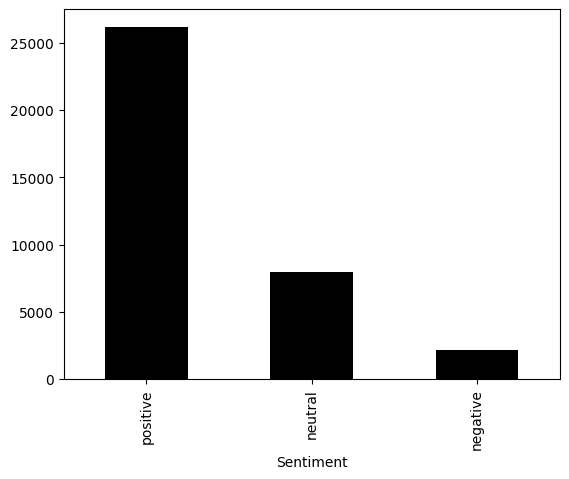

In [35]:
sentimentClasses = hotel_split_reviews["Sentiment"].value_counts()
sentimentClasses.plot(kind="bar", color='k');

In [21]:
hotel_split_reviews.head(10)

,sentence,hotel_name,Sentiment
0,"this was the ""headquarters"" for the family whe...",Eko Hotel,neutral
1,the facility is centrally located and encompa...,Eko Hotel,neutral
2,it was safe secure and included a buffet bre...,Eko Hotel,positive
3,it was an ideal spot and one of the best fami...,Eko Hotel,positive
4,with an outdoor pool and different hotels and...,Eko Hotel,negative
5,some of the rooms could do with some upgradi...,Eko Hotel,neutral
6,but overall it was great value for the cost of...,Eko Hotel,positive
7,excellent space for office programs/retreats,Eko Hotel,positive
8,rooms were fair enough; spacious and neat,Eko Hotel,positive
9,only issue i had was that the water in the ba...,Eko Hotel,neutral


In [37]:
hotel_split_reviews.groupby(["hotel_name", "Sentiment"]).size()

hotel_name               Sentiment
Eko Hotel                negative      529
                         neutral      2186
                         positive     6124
Four Points By Sheraton  negative      270
                         neutral      1378
                         positive     4475
Lagos Oriental           negative      390
                         neutral      1135
                         positive     5415
Radisson Blu VI          negative      509
                         neutral      1759
                         positive     5134
Sheraton Lagos           negative      459
                         neutral      1530
                         positive     5059
dtype: int64

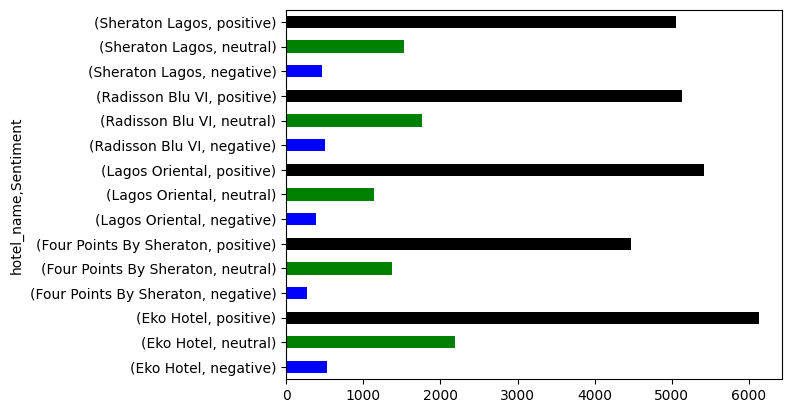

In [38]:
sentimentPerClass = hotel_split_reviews.groupby(["hotel_name", "Sentiment"]).size()
sentimentPerClass.plot(kind='barh', color=['b', 'g', 'k']);

In [41]:
hotel_split_reviews.to_csv("results/hotel_split_reviews-sentiments.csv", index=False)

TODO:
- After getting the topics, break the `hotel_split_reviews` table into the smaller tables that represents each hotel, by using their index numbers. 

- run the `further text cleaning` based on the hotel name and per topic and per sentiment.
    - Each topic wil have a break down of the overall sentiment and their keywords (using wordcloud)
    - Each sentiment will have a summary of what is spoken about. 

# Further Text Cleaning

In [45]:
# Load the regular expression library
import re

# Remove punctuation
hotel_split_reviews['processed_sentence'] = hotel_split_reviews['sentence'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
# hotel_split_reviews['processed_sentence'] = hotel_split_reviews['processed_sentence'].map(lambda x: x.lower())

# Print out the first rows of hotel_split_reviews
hotel_split_reviews['processed_sentence'].head()

<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
/var/folders/2x/3p0r8mnx6s7f7rwwg4fjmv3c0000gn/T/ipykernel_23683/240236133.py:5: DeprecationWarning: invalid escape sequence \.
  hotel_split_reviews['processed_sentence'] = hotel_split_reviews['sentence'].map(lambda x: re.sub('[,\.!?]', '', x))


0    this was the "headquarters" for the family whe...
1     the facility is centrally located and encompa...
2     it was safe secure and  included a buffet bre...
3     it was an ideal spot and one of the best fami...
4     with an outdoor pool and different hotels and...
Name: processed_sentence, dtype: object

In [46]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = hotel_split_reviews['processed_sentence'].values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['this', 'was', 'the', 'headquarters', 'for', 'the', 'family', 'when', 'we', 'visited', 'recently', 'for', 'our', 'nieces', 'wedding', 'to', 'her', 'nigerian', 'fiance']


In [47]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [48]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['hotel', 'hotels', 'lagos', 'nigeria', 'good', 'place', 'great', 'nice'])


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [52]:
hotel_split_reviews["data_lemmatized"] = data_lemmatized
hotel_split_reviews.head(2)

,sentence,hotel_name,Sentiment,processed_sentence,data_lemmatized
0,"this was the ""headquarters"" for the family whe...",Eko Hotel,neutral,"this was the ""headquarters"" for the family whe...","[family, visit, recently, niece, wed, nigerian..."
1,the facility is centrally located and encompa...,Eko Hotel,neutral,the facility is centrally located and encompa...,"[facility, centrally_locate, encompass, differ..."


# KEYWORDS Extraction Using WORDCLOUD

In [47]:
print(len(data_lemmatized))

36352


In [48]:
hotel_split_reviews["data_lemmatized"] = data_lemmatized
hotel_split_reviews.head(2)

,sentence,hotel_name,Sentiment,processed_sentence,data_lemmatized
0,"this was the ""headquarters"" for the family whe...",Eko Hotel,neutral,"this was the ""headquarters"" for the family whe...","[family, visit, recently, niece, wed, nigerian..."
1,the facility is centrally located and encompa...,Eko Hotel,neutral,the facility is centrally located and encompa...,"[facility, centrally_locate, encompass, differ..."


__This will be per topic and per sentiment__

In [ ]:
def get_list_values(data_structure, temp=[]):
    for item in data_structure:
        if type(item) == list:
            temp = get_list_values(item, temp)

        else:
            temp.append(item)

    return temp

text = ', '.join(get_list_values(data_lemmatized))
# text

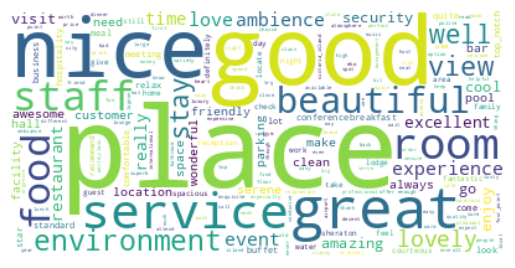

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(text))
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# LDA

In [70]:
%%capture
!pip install --upgrade wandb
!pip install hyperopt

In [ ]:
import wandb
import numpy as np
import pandas as pd
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import hyperopt
from hyperopt import fmin, tpe, hp, Trials


import gensim.corpora as corpora

# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)

# Create Corpus
data = data_lemmatized

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in data]

# View
print(corpus[:1][0][:30])

# data_processed = [doc.split() for doc in data]

# Define hyperparameters to search over
hyperparameters = {
    "num_topics": hp.choice("num_topics", range(5, 20)),
    "passes": hp.choice("passes", range(1, 10)),
    "alpha": hp.uniform("alpha", 0.1, 1.0),
    "eta": hp.uniform("eta", 0.1, 1.0)
}

# Define function to optimize hyperparameters and train LDA model
def objective(hyperparameters):
    num_topics = hyperparameters["num_topics"]
    passes = hyperparameters["passes"]
    alpha = hyperparameters["alpha"]
    eta = hyperparameters["eta"]


    # Train LDA model
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        alpha=alpha,
        eta=eta
    )
    
    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    # Log results to Weights and Biases
    wandb.log({
        "num_topics": num_topics,
        "passes": passes,
        "alpha": alpha,
        "eta": eta,
        "coherence": coherence_lda
    })

    # Return negative coherence score as we are minimizing
    return -coherence_lda

# Initialize Weights and Biases
!wandb init --project lda-project

# Use Hyperopt to optimize hyperparameters
trials = Trials()
best = fmin(objective, hyperparameters, algo=tpe.suggest, max_evals=10, trials=trials)

# Print best hyperparameters
best_hyperparameters = hyperopt.space_eval(hyperparameters, best)
print("Best hyperparameters:", best_hyperparameters)

# Log the best hyperparameters to Weights and Biases
wandb.config.update(best_hyperparameters)

# Train LDA model with best hyperparameters
num_topics = best_hyperparameters["num_topics"]
passes = best_hyperparameters["passes"]
alpha = best_hyperparameters["alpha"]
eta = best_hyperparameters["eta"]

# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes,
    alpha=alpha,
    eta=eta
)

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

# Log final results to Weights and Biases
wandb.log({
    "num_topics": num_topics,
    "passes": passes,
    "alpha": alpha,
    "eta": eta,
    "coherence": coherence_lda
})

In [40]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b, p):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=p,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return lda_model, coherence_model_lda.get_coherence()

In [ ]:
# # best_hyperparameters = {'alpha': 0.9700662822607893, 'eta': 0.6438566750092768, 'num_topics': 9, 'passes': 9}
best_hyperparameters = {'alpha': 0.9949359, 'eta': 0.6259744, 'num_topics': 8, 'passes': 5}

a = best_hyperparameters['alpha']
b = best_hyperparameters['eta']
p = best_hyperparameters['passes']
k = best_hyperparameters['num_topics']

lda_model, coherence_score = compute_coherence_values(corpus, dictionary, k, a, b, p)

print(coherence_score)

## Starts from here

In [3]:
!pwd

/Users/user/Documents/Dami's Thesis/hotel-analytics/notebooks


In [86]:
from pprint import pprint
import pickle

with open('../results/lda_model-8Topics.pkl', 'rb') as f:
    lda_model = pickle.load(f)

pprint(lda_model.print_topics())

[(0,
  '0.078*"environment" + 0.048*"good" + 0.034*"amazing" + 0.030*"oriental" + '
  '0.027*"star" + 0.027*"always" + 0.025*"location" + 0.025*"serene" + '
  '0.016*"business" + 0.015*"class"'),
 (1,
  '0.036*"get" + 0.036*"time" + 0.035*"visit" + 0.023*"relax" + 0.017*"lodge" '
  '+ 0.015*"come" + 0.014*"night" + 0.014*"day" + 0.013*"family" + '
  '0.013*"take"'),
 (2,
  '0.105*"room" + 0.031*"need" + 0.019*"standard" + 0.016*"still" + '
  '0.014*"look" + 0.014*"reception" + 0.012*"work" + 0.011*"give" + '
  '0.011*"point" + 0.010*"old"'),
 (3,
  '0.149*"service" + 0.051*"excellent" + 0.033*"security" + 0.032*"facility" + '
  '0.031*"customer" + 0.027*"hospitality" + 0.022*"fantastic" + '
  '0.018*"top_notch" + 0.014*"quality" + 0.012*"cozy"'),
 (4,
  '0.094*"beautiful" + 0.087*"view" + 0.077*"lovely" + 0.052*"experience" + '
  '0.037*"restaurant" + 0.017*"lagoon" + 0.017*"pool" + 0.016*"bar" + '
  '0.016*"chinese" + 0.015*"side"'),
 (5,
  '0.088*"staff" + 0.063*"ambience" + 0.060*"w

In [ ]:
alpha = lda_model.alpha 
eta = lda_model.eta

print("Alpha:", alpha)
print("Eta:", eta) 

In [42]:
corpus_pickle_path = '../results/corpus.pickle'
dictionary_pickle_path = '../results/dictionary.pickle'

# Unpickling the corpus
with open(corpus_pickle_path, 'rb') as f:
    corpus = pickle.load(f)

# # Unpickling the dictionary
# with open(dictionary_pickle_path, 'rb') as f:
#     dictionary = pickle.load(f)

In [ ]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_model_lda.get_coherence()

In [101]:
%%capture
!pip install --upgrade pandas pyLDAvis

In [98]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
# LDAvis_prepared
k = 8 # number of topics
LDAvis_data_filepath = os.path.join('../results/ldavis_tuned_'+str(k))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '../results/ldavis_tuned_'+ str(k) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.041362 -0.021851       1        1  13.901843
1      0.008407 -0.000255       2        1  13.314841
7      0.009237 -0.015466       3        1  12.599553
6      0.010747 -0.024106       4        1  12.349186
5      0.200076 -0.048137       5        1  12.227525
0     -0.240335 -0.143401       6        1  12.008568
4     -0.078221  0.282507       7        1  11.887001
3      0.048728 -0.029292       8        1  11.711482, topic_info=            Term         Freq        Total Category  logprob  loglift
72       service  2475.000000  2475.000000  Default  30.0000  30.0000
37          room  2069.000000  2069.000000  Default  29.0000  29.0000
73     beautiful  1579.000000  1579.000000  Default  28.0000  28.0000
15          food  1599.000000  1599.000000  Default  27.0000  27.0000
223        staff  1521.000000  1521.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
234   accessible    70.527846    76.663964   Topic8  -5.4601   2.0612
88          know    98.251611   106.890720   Topic8  -5.1286   2.0603
1387      worker    62.306118    67.999538   Topic8  -5.5841   2.0572
342         care    61.713978    67.550360   Topic8  -5.5936   2.0542
185           do    78.709535    89.019003   Topic8  -5.3504   2.0215

[299 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
392       1  0.008805  access
392       2  0.008805  access
392       3  0.008805  access
392       4  0.008805  access
392       5  0.008805  access
...     ...       ...     ...
583       4  0.008760    year
583       5  0.008760    year
583       6  0.008760    year
583       7  0.008760    year
583       8  0.928590    year

[2152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 8, 7, 6, 1, 5, 4])

In [39]:
topic_names = {
0: "Serene Environment",
1: "Leisure and Relaxation",
2: "Room Quality and Standards",
3: "Excellent Service and Hospitality",
4: "Beautiful Views and Dining Experiences",
5: "Welcoming Staff and Comfortable Stay",
6: "Event and Conference Spaces",
7: "Delightful Food and Home-like Feel"
}


def assign_topics(df, col_name, lda_model, corpus, topic_names):
    review_topic = []
    df = df.copy()
    # get the topic probability distribution for each sentence in the corpus
    topic_distributions = lda_model[corpus]

    # for each sentence, get the topic with the highest probability
    assigned_topics = [max(topic, key=lambda x: x[1])[0] for topic in topic_distributions]
    # print(assigned_topics)

     # print out the assigned topic name for each sentence
    for i, sentence in enumerate(df[col_name]):
        review_topic.append(topic_names[assigned_topics[i]])

    df["review_topic"] = review_topic

    return df


df = assign_topics(hotel_split_reviews, 'sentence', lda_model, corpus, topic_names)

In [106]:
df.head()

,sentence,hotel_name,Sentiment,processed_sentence,data_lemmatized,review_topic
0,"this was the ""headquarters"" for the family whe...",Eko Hotel,neutral,"this was the ""headquarters"" for the family whe...","[family, visit, recently, niece, wed, nigerian...",Family and Friends
1,the facility is centrally located and encompa...,Eko Hotel,neutral,the facility is centrally located and encompa...,"[facility, centrally_locate, encompass, differ...",Parking and Facilities
2,it was safe secure and included a buffet bre...,Eko Hotel,positive,it was safe secure and included a buffet bre...,"[safe, secure, include, buffet, breakfast, hug...",Scenic Views and Dining
3,it was an ideal spot and one of the best fami...,Eko Hotel,positive,it was an ideal spot and one of the best fami...,"[ideal, spot, good, family, orient]",Events and Conferences
4,with an outdoor pool and different hotels and...,Eko Hotel,negative,with an outdoor pool and different hotels and...,"[outdoor, pool, different, bar, complex, leave...",Scenic Views and Dining


In [107]:
df.sentence[4]

" with an outdoor pool and different hotels and bars on the complex you did not have to leave if you didn't want to!there were readily available cabs to take to different locations that you wanted to visit"

In [108]:
print(len(df))

36352


In [55]:
df.to_csv("../results/hotel_split_reviews-sentiments-and-ldatopics-latest-updated.csv", index=False)

In [60]:
eko_df = df[df.hotel_name=='Eko Hotel']
sheraton_df = df[df.hotel_name=='Sheraton Lagos']
radisson_df = df[df.hotel_name=='Radisson Blu VI']
fourpoints_df = df[df.hotel_name=='Four Points By Sheraton']
lagos_df = df[df.hotel_name=='Lagos Oriental']

In [111]:
assert((len(eko_df) + len(sheraton_df) + len(radisson_df) + len(fourpoints_df) + len(lagos_df))==len(df))

## EDA

In [4]:
!pwd

/Users/user/Documents/Dami's Thesis/hotel-analytics/notebooks


In [5]:
df = pd.read_csv("../results/hotel_split_reviews-sentiments-and-ldatopics-updated.csv")
df.shape

(36352, 6)

In [56]:
df.hotel_name.value_counts()

hotel_name
Eko Hotel                  8839
Radisson Blu VI            7402
Sheraton Lagos             7048
Lagos Oriental             6940
Four Points By Sheraton    6123
Name: count, dtype: int64

<Axes: xlabel='hotel_name', ylabel='Count'>

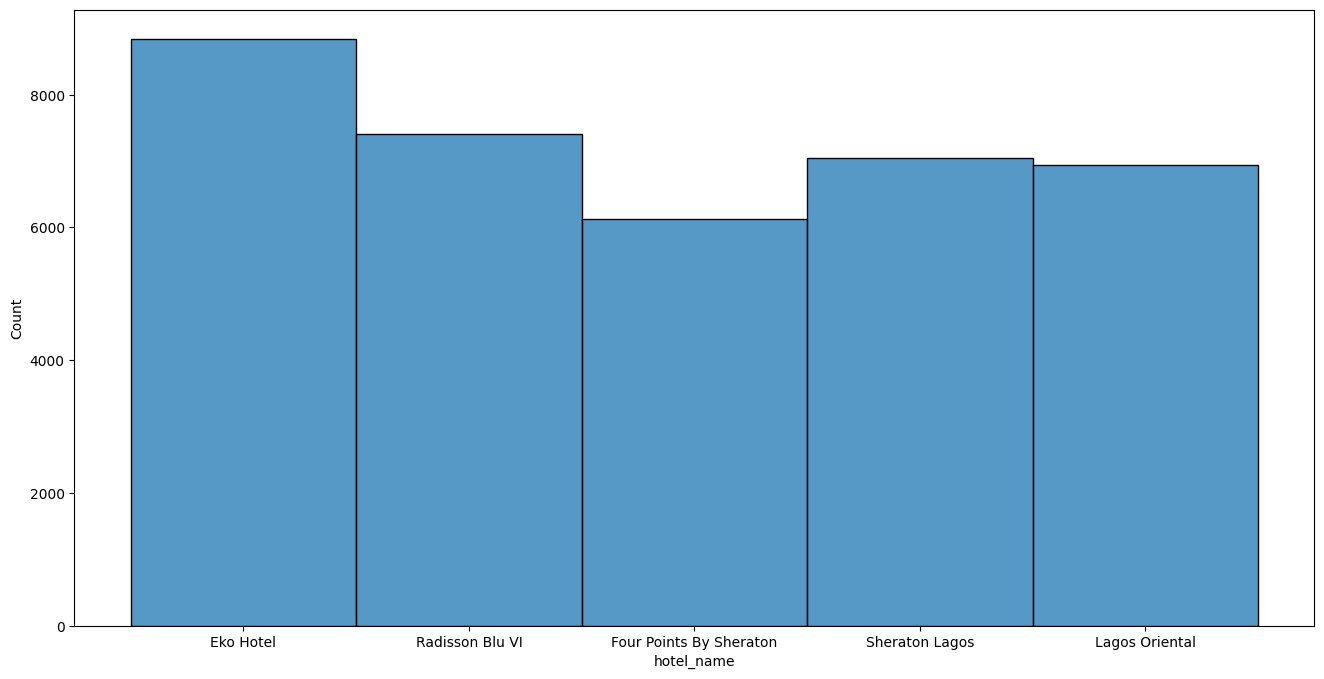

In [13]:
plt.figure(figsize=(16, 8))
sns.histplot(x="hotel_name", data=df)

In [57]:
df.review_topic.value_counts()

review_topic
Serene Environment                        5874
Welcoming Staff and Comfortable Stay      5002
Beautiful Views and Dining Experiences    4702
Excellent Service and Hospitality         4490
Leisure and Relaxation                    4331
Room Quality and Standards                4237
Event and Conference Spaces               3953
Delightful Food and Home-like Feel        3763
Name: count, dtype: int64

/var/folders/2x/3p0r8mnx6s7f7rwwg4fjmv3c0000gn/T/ipykernel_23683/1438855602.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot_.set_xticklabels(plot_.get_xticklabels(), rotation=45, horizontalalignment='right')


[Text(0, 0, 'Leisure and Relaxation'),
 Text(1, 0, 'Excellent Service and Hospitality'),
 Text(2, 0, 'Delightful Food and Home-like Feel'),
 Text(3, 0, 'Serene Environment'),
 Text(4, 0, 'Room Quality and Standards'),
 Text(5, 0, 'Event and Conference Spaces'),
 Text(6, 0, 'Beautiful Views and Dining Experiences'),
 Text(7, 0, 'Welcoming Staff and Comfortable Stay')]

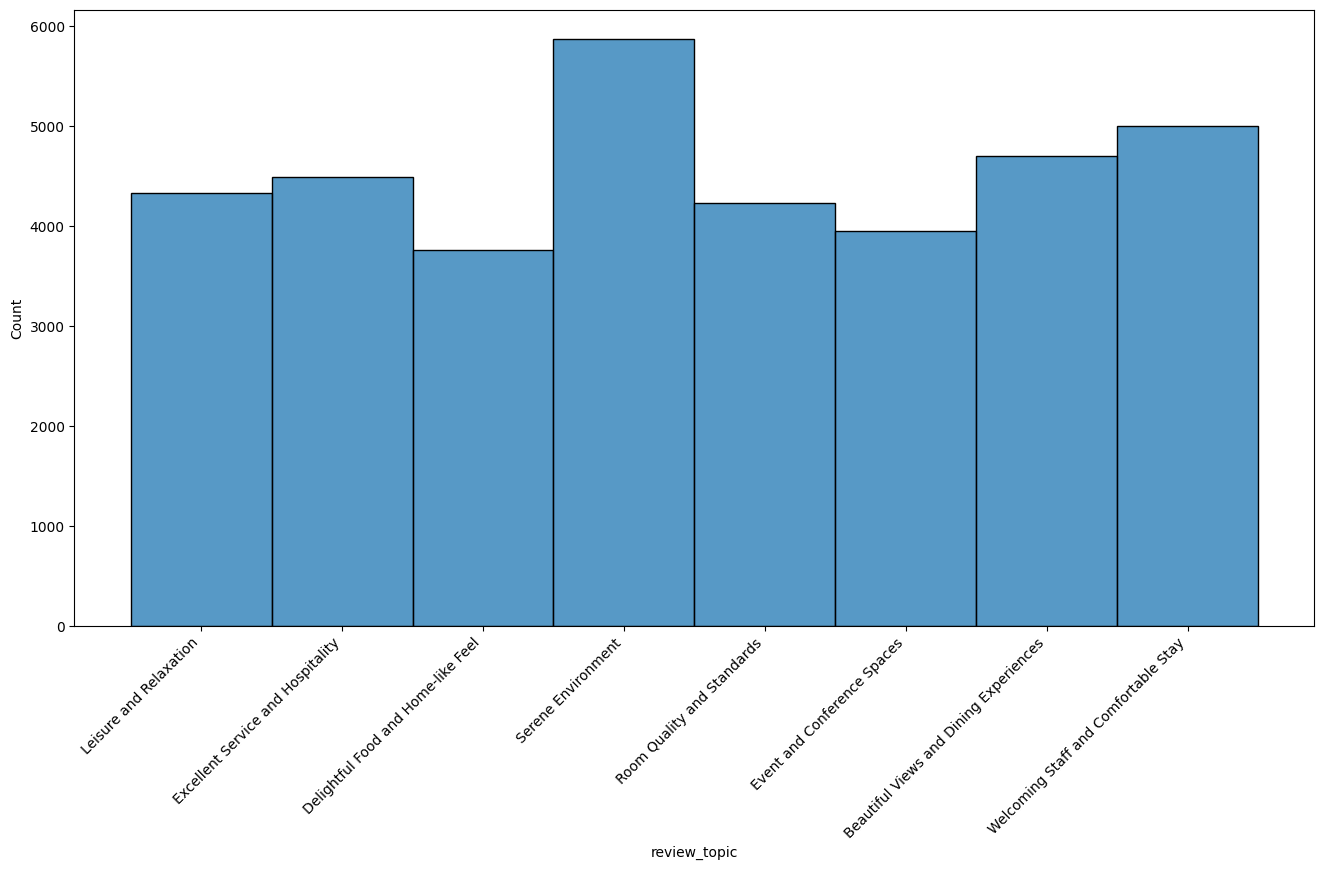

In [58]:
plt.figure(figsize=(16, 8))
plot_ = sns.histplot(x="review_topic", data=df)
#rotate x-axis labels
plot_.set_xticklabels(plot_.get_xticklabels(), rotation=45, horizontalalignment='right')

In [59]:
df.Sentiment.value_counts()

Sentiment
positive    26207
neutral      7988
negative     2157
Name: count, dtype: int64

<Axes: xlabel='Sentiment', ylabel='Count'>

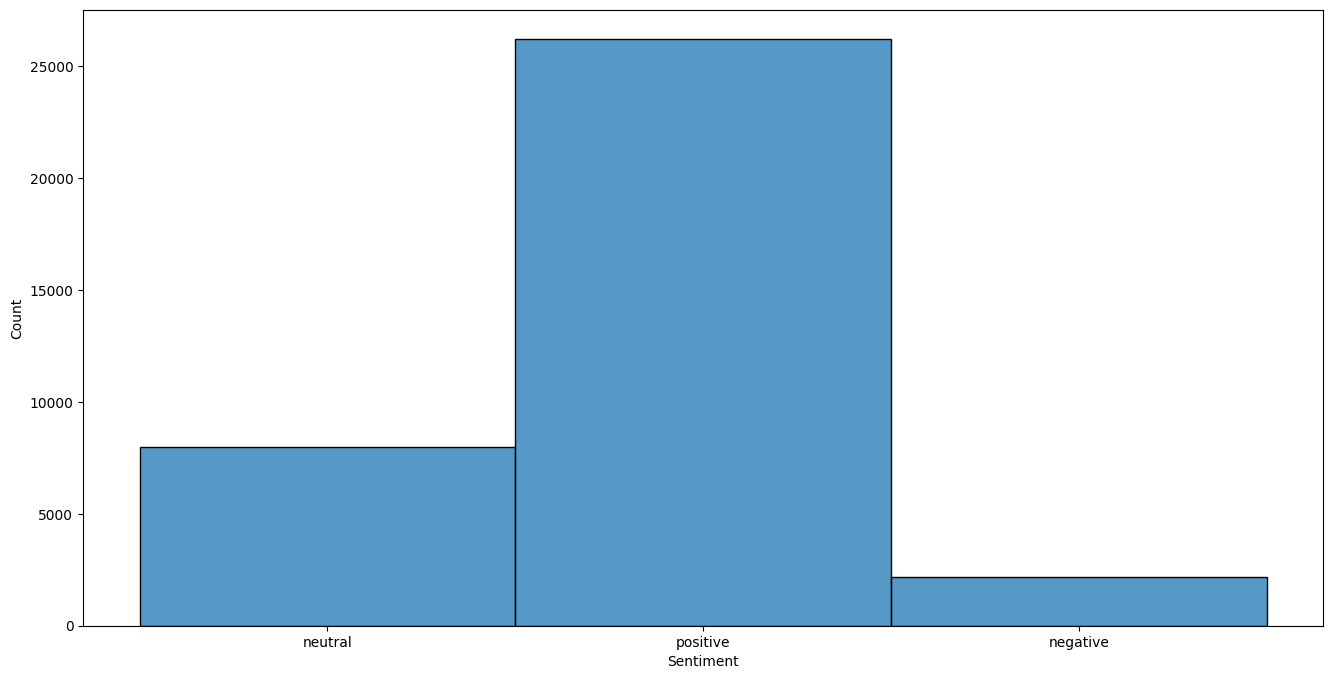

In [17]:
plt.figure(figsize=(16, 8))
sns.histplot(x="Sentiment", data=df)

In [96]:
value_counts = eko_df.Sentiment.value_counts()

# Calculate the percentage
percentage = value_counts / len(eko_df) * 100

# Print the value counts and percentage
result = pd.concat([value_counts, percentage], axis=1, keys=['Value Count', 'Percentage'])
print(result)

           Value Count  Percentage
Sentiment                         
positive          6124   69.283856
neutral           2186   24.731304
negative           529    5.984840


<Figure size 1600x800 with 0 Axes>

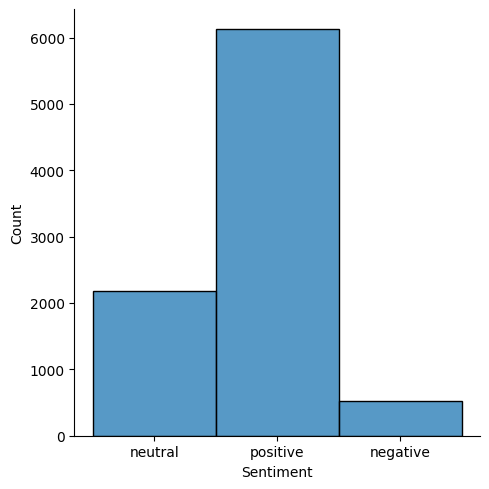

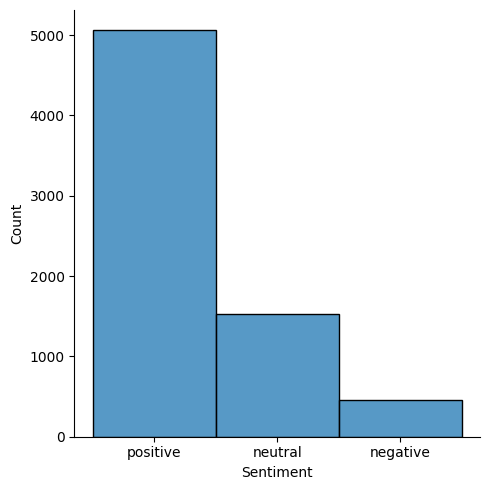

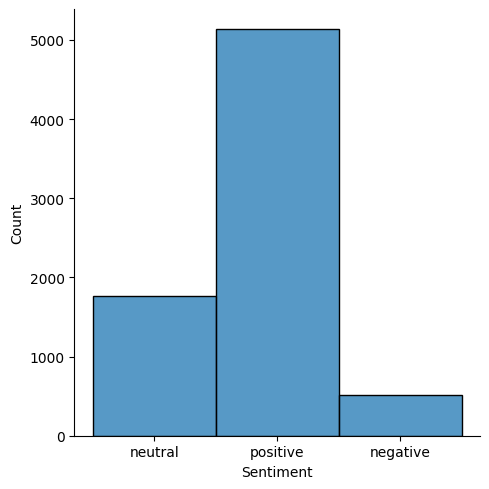

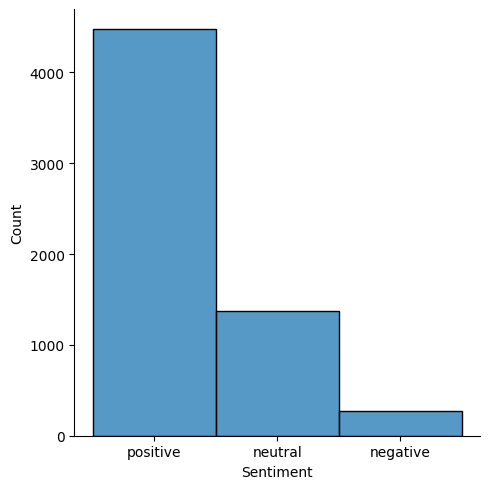

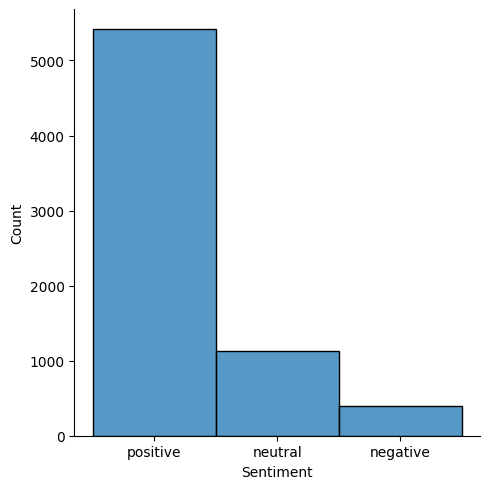

In [22]:
## 
# all_df = [eko_df, sheraton_df, radisson_df, fourpoints_df, lagos_df]
# for hotel in all_df:
plt.figure(figsize=(16, 8))
sns.displot(x="Sentiment", data=eko_df)
sns.displot(x="Sentiment", data=sheraton_df)
sns.displot(x="Sentiment", data=radisson_df)
sns.displot(x="Sentiment", data=fourpoints_df)
sns.displot(x="Sentiment", data=lagos_df)

In [6]:
eko_df = df[df.hotel_name=='Eko Hotel']
sheraton_df = df[df.hotel_name=='Sheraton Lagos']
radisson_df = df[df.hotel_name=='Radisson Blu VI']
fourpoints_df = df[df.hotel_name=='Four Points By Sheraton']
lagos_df = df[df.hotel_name=='Lagos Oriental']

In [53]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Word cloud per sentiment in each hotel

stopwords = list(STOP_WORDS)
stopwords_ = stopwords + ["hotel", "hotels", "lagos", "nigeria", "nigerians", "good", "great", "nice", "place"]
nlp = spacy.load('en_core_web_sm')

def tokenize_text(input_text):
    doc = nlp(input_text)
    tokens = [token.text for token in doc]
    return tokens

def generate_wordcloud(text, stopwords=stopwords_):
    # Tokenize the joined text into individual words
    tokens = tokenize_text(text)

    # Remove stop words from the tokens
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords]

    # Join the filtered tokens back into a single string
    filtered_text = " ".join(filtered_tokens)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords).generate(filtered_text)

    # Display word cloud in Streamlit app
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


positive


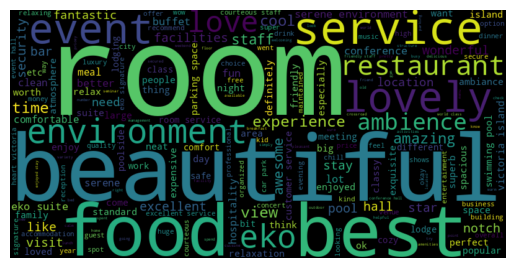

neutral


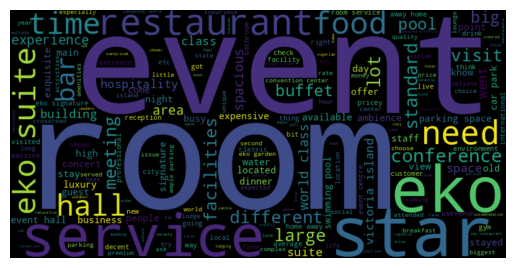

negative


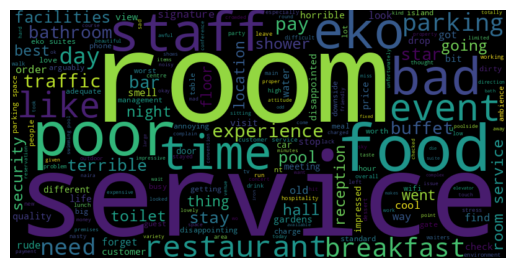



positive


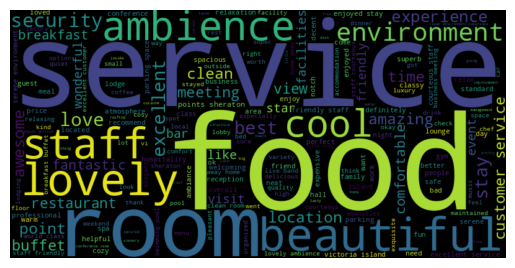

neutral


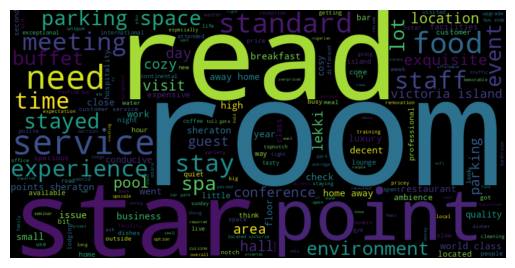

negative


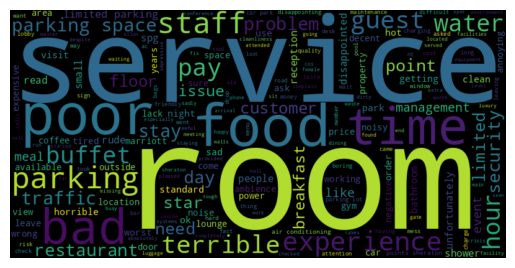



positive


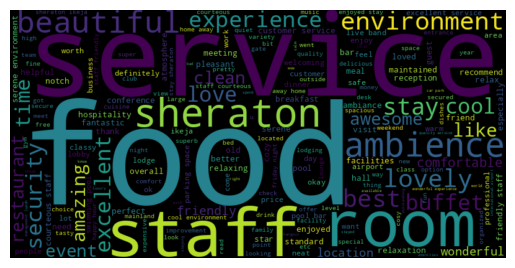

neutral


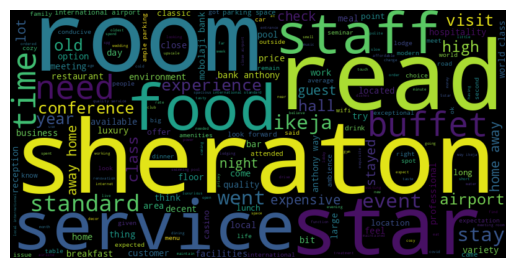

negative


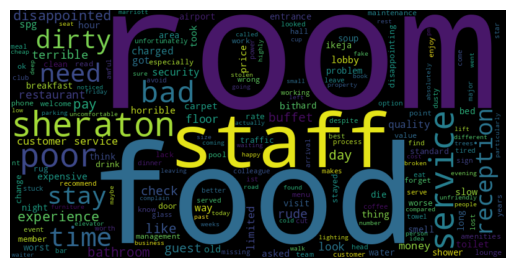



positive


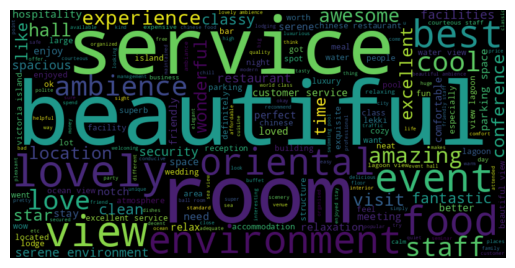

neutral


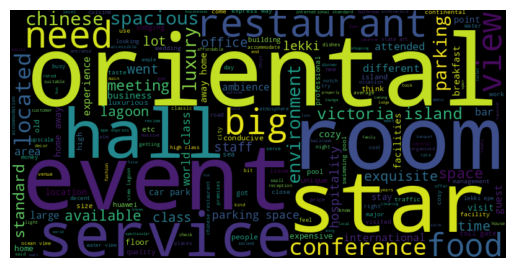

negative


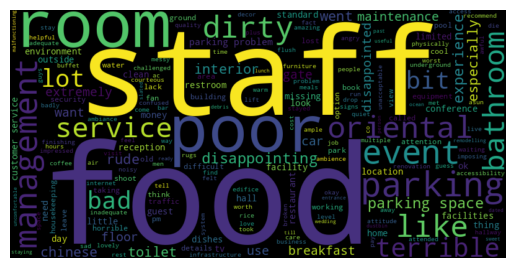



positive


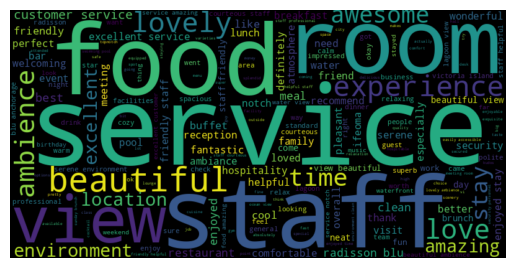

neutral


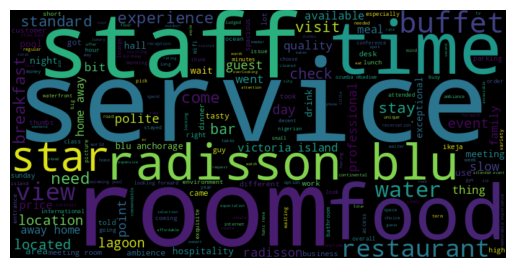

negative


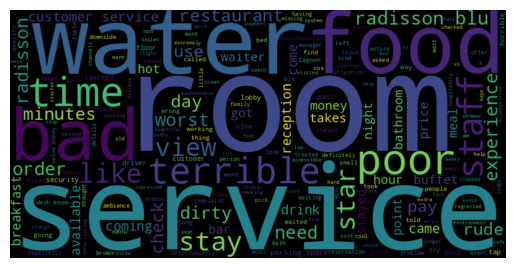

In [56]:
all_df = [eko_df, sheraton_df, radisson_df, fourpoints_df, lagos_df]
sentiments = ["positive", "neutral", "negative"]
for hotel in all_df:
    for sentiment in sentiments:
        reviews_text = ". ".join(hotel[hotel["Sentiment"]==sentiment]["sentence"])
        print(f"{sentiment}")
        generate_wordcloud(reviews_text)
    print("\n")

In [57]:
def score_smoke(rate: str):
    rates = {
        "never smoked": 1, 
        "weekly smoke": 2
    }

    return rates[rate.lower()]


print(score_smoke("Weekly Smoke"))

2
